In [1]:
# from zipfile import ZipFile 

# # specifying the zip file name 
# file_name = "/kaggle/input/potato-leafs/PlantVillage"

# # opening the zip file in READ mode 
# with ZipFile(file_name, 'r') as zip: 

#     # extracting all the files 
#     print('Extracting all the files now...') 
#     zip.extractall() 

#### Importing some important libraries

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
from keras import regularizers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 40
EPOCHS = 25
CHANNEL = 3

#### Converting dataset into batches

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/potato-leafs/PlantVillage',
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


2022-12-28 11:34:46.891076: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-28 11:34:46.892117: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-28 11:34:47.180941: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-28 11:34:47.181854: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-28 11:34:47.182670: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)  # it shows length 68 inplace of 2152 because we divide the dataset into batches. So 32*68 = 2176

54

2022-12-28 11:34:52.521933: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


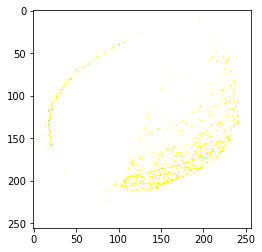

In [7]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy())

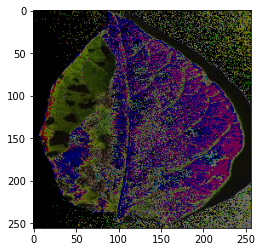

In [8]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("int8"))

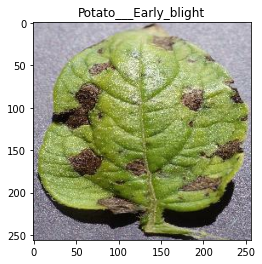

In [9]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])

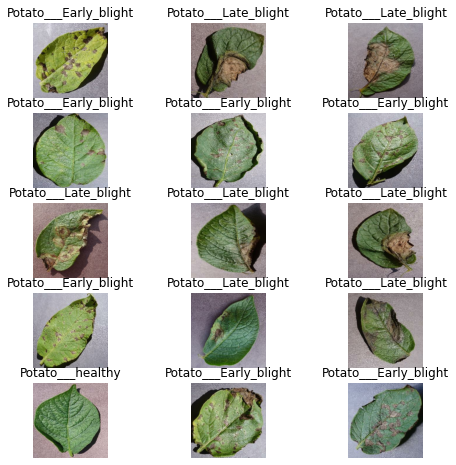

In [10]:
plt.figure(figsize = (8,8))
for image_batch, label_batch in dataset.take(1):
    for i in range(15):
        plt.subplot(5,3,i+1)
        
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

#### Creating a function for spliting datset into train, test and validation

In [11]:
def dataset_partitions(ds, train_split = 0.8, test_split=0.1, val_split=0.1, shuffle = True, shuffle_size = 5):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 12)
        
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)               # it takes 80% data from dataset 'ds'
    val_ds = ds.skip(train_size).take(val_size)  # it takes 10% data from remaining 20% data of dataset
    test_ds = ds.skip(train_size).skip(val_size) # it takes remaining 10% data from dataset
    
    return train_ds, val_ds, test_ds

In [12]:
train_ds, val_ds, test_ds = dataset_partitions(dataset)

In [13]:
len(train_ds)

43

In [14]:
len(val_ds)

5

In [15]:
len(test_ds)

6

#### for increasing the training performance fast we perform some operations

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### doing some preprocessing

In [17]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

#### for making model more robust we use data augmentation

In [18]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)  
])

#### Building Model

* Regularization (_kernel_regularizer_) <br>
Regularization optimizes a model by penalizing complex models, therefore minimizing loss and complexity. Thus this forces our neural network to be simpler. Here we will use an L2 regularizer, as it is the most common and is more stable than an L1 regularizer. Here we’ll add a regularizer to the second and third layers of our network with a learning rate (lr) of 0.01.


In [19]:
n_classes = 3

models = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation = 'relu', input_shape = (BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE, CHANNEL)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu',kernel_regularizer=regularizers.l2(l=0.01)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu',kernel_regularizer=regularizers.l2(l=0.01)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu',kernel_regularizer=regularizers.l2(l=0.01)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu',kernel_regularizer=regularizers.l2(l=0.01)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu',kernel_regularizer=regularizers.l2(l=0.01)),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes, activation='softmax'),        
])

In [20]:
models.build(input_shape = (BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE, CHANNEL))

#### Summary of model

In [21]:
models.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (40, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (40, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (40, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (40, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (40, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (40, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (40, 60, 60, 64)         

#### Compilation of model

In [22]:
models.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

#### fitting the model

In [23]:
history = models.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/25


2022-12-28 11:35:08.604786: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


43/43 [==============================] - 28s 154ms/step - loss: 2.4307 - accuracy: 0.5134 - val_loss: 1.4595 - val_accuracy: 0.7450
Epoch 2/25
43/43 [==============================] - 3s 74ms/step - loss: 1.1072 - accuracy: 0.6610 - val_loss: 0.9090 - val_accuracy: 0.6600
Epoch 3/25
43/43 [==============================] - 3s 75ms/step - loss: 0.8086 - accuracy: 0.7547 - val_loss: 0.6569 - val_accuracy: 0.8100
Epoch 4/25
43/43 [==============================] - 3s 74ms/step - loss: 0.6508 - accuracy: 0.8017 - val_loss: 0.5492 - val_accuracy: 0.8800
Epoch 5/25
43/43 [==============================] - 3s 74ms/step - loss: 0.5374 - accuracy: 0.8593 - val_loss: 0.5302 - val_accuracy: 0.8650
Epoch 6/25
43/43 [==============================] - 3s 74ms/step - loss: 0.5626 - accuracy: 0.8262 - val_loss: 0.4852 - val_accuracy: 0.8800
Epoch 7/25
43/43 [==============================] - 3s 74ms/step - loss: 0.4804 - accuracy: 0.8651 - val_loss: 0.4828 - val_accuracy: 0.8850
Epoch 8/25
43/43 [====

#### Checking Scores of model

In [24]:
scores = models.evaluate(test_ds)
loss, accuracy = scores

6/6 [==============================] - 4s 127ms/step - loss: 0.3157 - accuracy: 0.9138


In [25]:
print("Accuracy of model is : ",accuracy*100)
print("Loss of model is : ",loss*100)

Accuracy of model is :  91.37930870056152
Loss of model is :  31.573259830474854


In [26]:
history

In [27]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 43}

In [28]:
history.params.keys()

dict_keys(['verbose', 'epochs', 'steps'])

In [29]:
history.history['accuracy']

[0.5133720636367798,
 0.6610465049743652,
 0.7546511888504028,
 0.8017441630363464,
 0.8593023419380188,
 0.8261628150939941,
 0.8651162981987,
 0.859883725643158,
 0.8825581669807434,
 0.8732557892799377,
 0.8988372087478638,
 0.8965116143226624,
 0.9087209105491638,
 0.8924418687820435,
 0.9104651212692261,
 0.9017441868782043,
 0.9046511650085449,
 0.9052325487136841,
 0.9133720993995667,
 0.9110465049743652,
 0.9052325487136841,
 0.9023255705833435,
 0.9156976938247681,
 0.9174418449401855,
 0.9174418449401855]

#### Plotting graph for better understanding between validation and training

In [30]:
accu = history.history['accuracy']
val_accu = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training & Validation Accuracy')

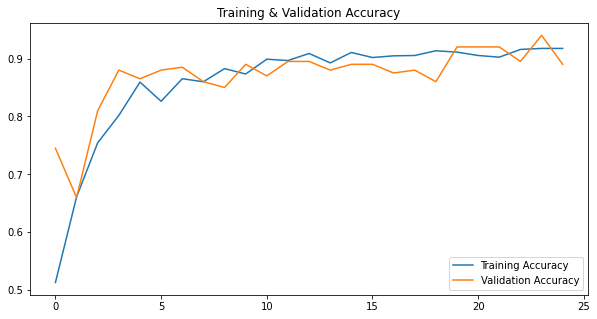

In [31]:
plt.figure(figsize=(10,5))
plt.subplot(1,1,1)

plt.plot(range(EPOCHS),accu,label="Training Accuracy")
plt.plot(range(EPOCHS),val_accu,label="Validation Accuracy")

plt.legend(loc='lower right')
plt.title('Training & Validation Accuracy')

Text(0.5, 1.0, 'Training & Validation Loss')

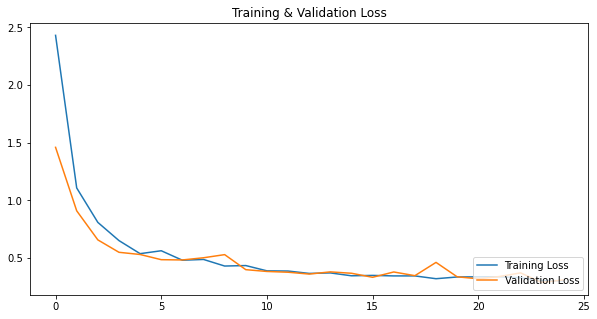

In [32]:
plt.figure(figsize=(10,5))
plt.subplot(1,1,1)

plt.plot(range(EPOCHS),loss,label="Training Loss")
plt.plot(range(EPOCHS),val_loss,label="Validation Loss")

plt.legend(loc='lower right')
plt.title('Training & Validation Loss')

first image to predict
actual:  Potato___healthy
predicted :  Potato___healthy


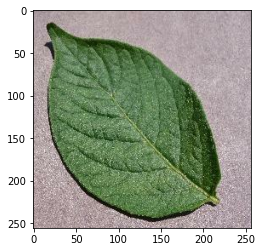

In [33]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('first image to predict')
    plt.imshow(first_image)
    print('actual: ',class_names[first_label])
    
    batch_prediction = models.predict(images_batch)
    print('predicted : ',class_names[np.argmax(batch_prediction[0])])

#### Creating a function for making prediction

In [34]:
def predict(models,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #creating a batch
    
    predictions = models.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round((np.max(predictions[0])*100),2)
    return predicted_class, confidence

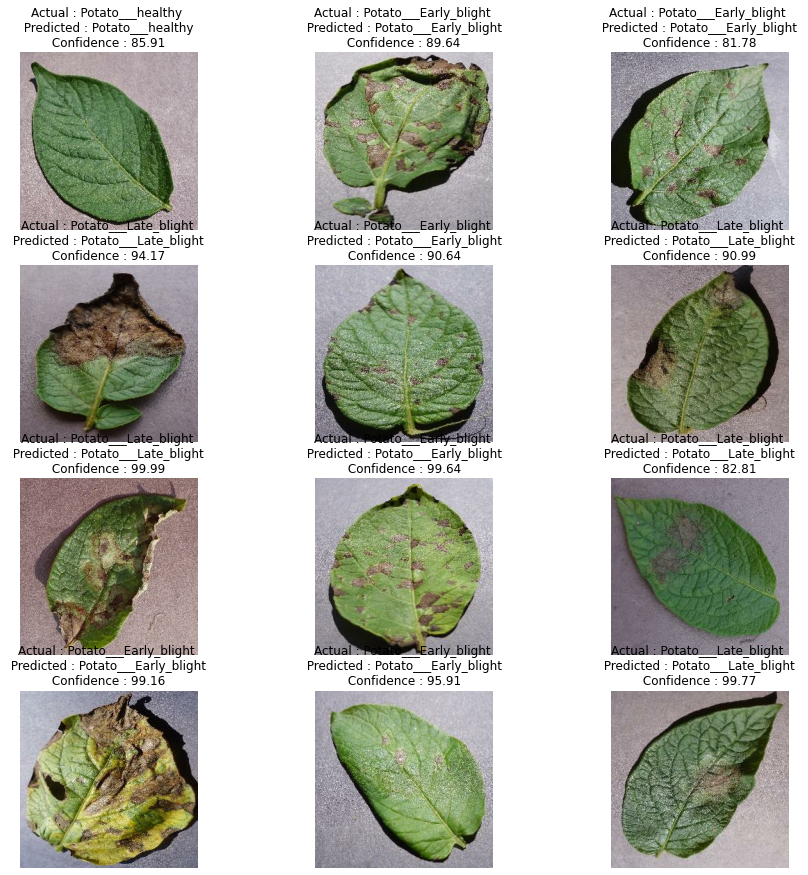

In [35]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(models, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f'Actual : {actual_class} \n Predicted : {predicted_class} \n Confidence : {confidence} ')
        plt.axis('off')

#### Saving model version

In [36]:
models.save('/kaggle/working/')

2022-12-28 11:37:28.094125: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
